# 3.1 Parabolic model problem
In this unit we want to turn to instationary problems. And we will start with a very basic setup: implicit Euler time stepping for the convection diffusion equation. After the main part of this tutorial we have supplementary material to extend the case in several regards.



We are solving the unsteady heat equation 

$$\text{find } u:[0,T] \to H_{0,D}^1 \quad \int_{\Omega} \partial_t u v + a\int_{\Omega} \nabla u \nabla v + b \cdot \nabla u v = \int f v  \quad \forall v \in H_{0,D}^1, \quad u(t=0) = u_0$$

with a suitable advective field $b$ (the wind).

In [5]:
#imports
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw

* Geometry: $(-1,1)^2$
* Dirichlet boundaries everywhere
* Mesh

In [6]:
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
shape = Rectangle(2,2).Face().Move((-1,-1,0))
shape.edges.Min(X).name="left"
shape.edges.Max(X).name="right"
shape.edges.Min(Y).name="bottom"
shape.edges.Max(Y).name="top"


In [7]:
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.25))
fes = H1(mesh, order=3, dirichlet="bottom|right|left|top")
u,v = fes.TnT()
time = 0.0
dt = 0.01

We define the field $b$ (the wind) as 

$$b(x,y) := (2y(1-x^2),-2x(1-y^2)).$$

In [8]:
b = CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
Draw(b,mesh,"wind", vectors={"grid_size": 32}, order=3)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

* bilinear forms for 
 * convection-diffusion stiffness and 
 * mass matrix separately.
* non-symmetric memory layout for the mass matrix so that a and m have the same sparsity pattern.

In [9]:
a = BilinearForm(fes, symmetric=False)
a += 0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx
a.Assemble()

m = BilinearForm(fes, symmetric=False)
m += u*v*dx
m.Assemble()

## Implicit Euler method
$$
  \underbrace{(M + \Delta t A)}_{M^\ast} u^{n+1} = M u^n + \Delta tf^{n+1}
$$

or in an incremental form:

$$
  M^\ast (u^{n+1} - u^n) = - \Delta t A u^n + \Delta tf^{n+1}.
$$

* Incremental form: $u^{n+1} - u^n$ has homogeneous boundary conditions (unless boundary conditions are time-dependent).
* For the time stepping method: set up linear combinations of matrices.
* (Only) if the sparsity pattern of the matrices agree we can copy the pattern and sum up the entries.

First, we create a matrix of same format as m.mat and compare number of non-zero entries and sparsity pattern:

In [10]:
mstar = m.mat.CreateMatrix()
print(f"m.mat.nze = {m.mat.nze}, a.mat.nze={a.mat.nze}, mstar.nze={mstar.nze}")

To access the entries we use the vector of nonzero-entries:

In [12]:
print(f"mstar.nze={mstar.nze}, len(mstar.AsVector())={len(mstar.AsVector())}")

mstar.nze=11257, len(mstar.AsVector())=11257


In [13]:
# print(mstar.AsVector())

 0.00520833
 0.00260417
 0.00260417
 -0.000520833
 8.68056e-05
 -0.000520833
 8.68056e-05
 -0.000260417
 -1.32137e-19
 0.000173611
 0.00823929
 0.00207589
 0.00204376
 0.00411964
 -0.000415177
 6.91962e-05
 -0.000408752
 6.81253e-05
 -0.000823929
 0.000137321
 -0.000207589
 1.05879e-19
 -0.000204376
 -1.02491e-19
 0.000138392
 0.000136251
 0.00520833
 0.00260417
 0.00260417
 -0.000520833
 8.68056e-05
 -0.000520833
 8.68056e-05
 -0.000260417
 1.32137e-19
 0.000173611
 0.00827496
 0.00209025
 0.00204723
 0.00413748
 -0.000418049
 6.96749e-05
 -0.000409446
 6.82411e-05
 -0.000827496
 0.000137916
 -0.000209025
 1.06726e-19
 -0.000204723
 -1.04185e-19
 0.00013935
 0.000136482
 0.00260417
 0.0195488
 0.00333868
 0.00643574
 0.00717025
 -0.000520833
 -8.68056e-05
 -0.000260417
 -1.40607e-19
 -0.000667736
 0.000111289
 -0.00128715
 0.000214525
 -0.00143405
 0.000239008
 -0.000333868
 -1.72795e-19
 -0.000383157
 1.96512e-19
 0.000173611
 0.000222579
 0.000255438
 0.00333868
 0.0199715
 0.002826

Using the vector we can build the linear combination of the a and the m matrix:

In [14]:
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
# corresponds to M* = M + dt * A
invmstar = mstar.Inverse(freedofs=fes.FreeDofs())

We set the r.h.s. $f = exp(-6 ((x+\frac12)^2+y^2)) - exp(-6 ((x-\frac12)^2+y^2))$

In [15]:
f = LinearForm(fes)
gaussp = exp(-6*((x+0.5)*(x+0.5)+y*y))-exp(-6*((x-0.5)*(x-0.5)+y*y))
Draw(gaussp,mesh,"f", deformation=True)
f += gaussp*v*dx
f.Assemble()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

and the initial data: $u_0 = (1-y^2)x$

In [16]:
gfu = GridFunction(fes)
gfu.Set((1-y*y)*x) # note that boundary conditions remain
scene = Draw(gfu,mesh,"u")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

we define a simple time loop including some visualization sampling:

In [17]:
def TimeStepping(invmstar, initial_cond = None, t0 = 0, tend = 2, 
                 nsamples = 10):
    if initial_cond:
        gfu.Set(initial_cond)
    cnt = 0; time = t0
    sample_int = int(floor(tend / dt / nsamples)+1)
    gfut = GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)
    while time < tend - 0.5 * dt:
        res = dt * f.vec - dt * a.mat * gfu.vec
        gfu.vec.data += invmstar * res
        print("\r",time,end="")
        scene.Redraw()
        if cnt % sample_int == 0:
            gfut.AddMultiDimComponent(gfu.vec)
        cnt += 1; time = cnt * dt
    return gfut

In [18]:
%%time
gfut = TimeStepping(invmstar, (1-y*y)*x)

 1.99CPU times: user 401 ms, sys: 45.8 ms, total: 446 ms
Wall time: 741 ms


In [27]:
Draw(gfut, mesh, interpolate_multidim=True, animate=True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [19]:
def exact_TimeStepping(invmstar, initial_cond = None, t0 = 0, tend = 2, 
                 nsamples = 10):
    if initial_cond:
        exact_gfu.Set(initial_cond)
    cnt = 0; time = t0
    sample_int = int(floor(tend / dt / nsamples)+1)
    exact_gfut = GridFunction(exact_gfu.space,multidim=0)
    exact_gfut.AddMultiDimComponent(exact_gfu.vec)
    while time < tend - 0.5 * dt:
        res = dt * f.vec - dt * a.mat * exact_gfu.vec
        exact_gfu.vec.data += invmstar * res
        print("\r",time,end="")
        if cnt % sample_int == 0:
            exact_gfut.AddMultiDimComponent(exact_gfu.vec)
        cnt += 1; time = cnt * dt
    return exact_gfut

In [20]:
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.03))
fes = H1(mesh, order=2, dirichlet="bottom|right|left|top")
u,v = fes.TnT()
time = 0.0
dt = 0.001
b = CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
a = BilinearForm(fes, symmetric=False)
a += 0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx
a.Assemble()

m = BilinearForm(fes, symmetric=False)
m += u*v*dx
m.Assemble()

mstar = m.mat.CreateMatrix()
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
# corresponds to M* = M + dt * A
invmstar = mstar.Inverse(freedofs=fes.FreeDofs())
f = LinearForm(fes)
gaussp = exp(-6*((x+0.5)*(x+0.5)+y*y))-exp(-6*((x-0.5)*(x-0.5)+y*y))
f += gaussp*v*dx
f.Assemble()

exact_gfu = GridFunction(fes)
exact_gfu.Set((1-y*y)*x) # note that boundary conditions remain

exact_gfut = exact_TimeStepping(invmstar, (1-y*y)*x)

 1.9990000000000001441.613

In [21]:
err = sqrt (Integrate ( (gfut-exact_gfut)*(gfut-exact_gfut), mesh))
err

6.190066109207093e-07

In [22]:
mesh_size = [0.5, 0.25, 0.125,  0.0625]# ,0.03125] #, 0.015625]
dofs = []
errors = []

for h in mesh_size:
    mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=h))
    fes = H1(mesh, order=2, dirichlet="bottom|right|left|top")
    dofs.append(fes.ndof)
    u,v = fes.TnT()
    time = 0.0
    dt = 0.001
    b = CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
    a = BilinearForm(fes, symmetric=False)
    a += 0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx
    a.Assemble()

    m = BilinearForm(fes, symmetric=False)
    m += u*v*dx
    m.Assemble()

    mstar = m.mat.CreateMatrix()
    mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
    # corresponds to M* = M + dt * A
    invmstar = mstar.Inverse(freedofs=fes.FreeDofs())
    f = LinearForm(fes)
    gaussp = exp(-6*((x+0.5)*(x+0.5)+y*y))-exp(-6*((x-0.5)*(x-0.5)+y*y))
    f += gaussp*v*dx
    f.Assemble()

    gfu = GridFunction(fes)
    gfu.Set((1-y*y)*x) # note that boundary conditions remain

    gfut = TimeStepping(invmstar, (1-y*y)*x)    
        
    err = sqrt (Integrate ( (gfut-exact_gfut)*(gfut-exact_gfut), mesh))
    errors.append(err)

 1.999000000000000144

In [23]:
errors

[0.00406936230165371,
 0.00046512909680945336,
 4.690498206636391e-05,
 5.657850389467041e-06]

In [25]:
import numpy as np
for i in range(len(mesh_size)-1):
    print("Convergence rate:", np.log(errors[i+1]/errors[i])/np.log(mesh_size[i+1]/mesh_size[i]))

Convergence rate: 3.129099633882909
Convergence rate: 3.309818119019907
Convergence rate: 3.0514152352171826


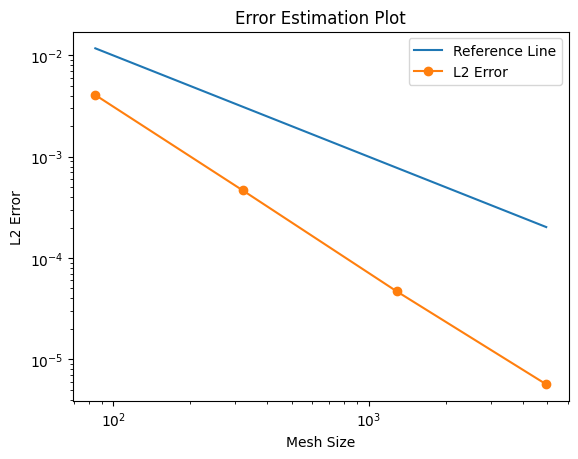

In [26]:
import matplotlib.pyplot as plt
plt.loglog(dofs, np.divide(np.ones(len(dofs)), np.array(dofs)), label="Reference Line")
plt.loglog(dofs,errors, "-o", label="L2 Error")
plt.title("Error Estimation Plot")
plt.xlabel("Mesh Size")
plt.ylabel("L2 Error")
plt.legend()
plt.show()